In [1]:
IMPORTANT_KEYPOINTS= [
    "nose",
    "left_eye_inner",
    "left_eye",
    "left_eye_outer",
    "right_eye_inner",
    "right_eye",
    "right_eye_outer",
    "left_ear",
    "right_ear",
    "mouth_left",
    "mouth_right",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_wrist",
    "right_wrist",
    "left_pinky",
    "right_pinky",
    "left_index",
    "right_index",
    "left_thumb",
    "right_thumb",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_ankle",
    "right_ankle",
    "left_heel",
    "right_heel",
    "left_foot_index",
    "right_foot_index",
]

# Trích xuất Keypoints từ ảnh

Notebook này có nhiệm vụ:
1. Tiền xử lý ảnh từ thư mục `/data/train`
2. Trích xuất các keypoints sử dụng MediaPipe
3. Lưu các keypoints vào file CSV trong thư mục mới `/data_cleaned`

In [2]:
# Import các thư viện cần thiết
import os
import sys
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm  # Sử dụng tqdm thông thường thay vì tqdm.notebook
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Đường dẫn gốc của dự án
ROOT_PATH = Path('d:/GiaoPhan_Workspace/sem_6/pbl5/baby_posture_analysis')
# Thêm đường dẫn vào sys.path để import các module tự định nghĩa
sys.path.append(str(ROOT_PATH))

# Import các module tự định nghĩa
from app.utils.image_helper import Image_Helper, Image_Rotation_Helper
from app.utils.keypoints_helper import KeypointsExtractorHelper

In [3]:
# Khởi tạo các đối tượng MediaPipe
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# Định nghĩa đường dẫn
DATA_SOURCE_PATH = ROOT_PATH / 'data' / 'train'
DATA_DEST_PATH = ROOT_PATH / 'data_cleaned'
CSV_OUTPUT_PATH = DATA_DEST_PATH / 'keypoints_extract.csv'

# Danh sách các lớp cần xử lý
CLASSES = ['nam_nghieng', 'nam_ngua', 'nam_sap']

# Kiểm tra và tạo thư mục đích nếu chưa tồn tại
if not DATA_DEST_PATH.exists():
    os.makedirs(DATA_DEST_PATH)
    print(f"Đã tạo thư mục {DATA_DEST_PATH}")
else:
    print(f"Thư mục {DATA_DEST_PATH} đã tồn tại")

Đã tạo thư mục d:\GiaoPhan_Workspace\sem_6\pbl5\baby_posture_analysis\data_cleaned


In [4]:
# Định nghĩa lớp KeypointExtractor để xử lý trích xuất keypoints từ ảnh
class KeypointExtractor:
    def __init__(self, mp_pose, important_keypoints):
        """
        Khởi tạo đối tượng KeypointExtractor
        
        Args:
            mp_pose: Đối tượng mp.solutions.pose
            important_keypoints: Danh sách các keypoint quan trọng cần trích xuất
        """
        self.mp_pose = mp_pose
        self.important_keypoints = important_keypoints
        # Khởi tạo pose detector từ MediaPipe
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            min_detection_confidence=0.5
        )
        # Khởi tạo các helper
        self.image_helper = Image_Helper()
        self.image_rotation_helper = Image_Rotation_Helper()
        self.keypoints_helper = KeypointsExtractorHelper(important_keypoints, mp_pose)
    
    def preprocess_image(self, image_path):
        """
        Tiền xử lý ảnh từ đường dẫn
        
        Args:
            image_path: Đường dẫn đến file ảnh
            
        Returns:
            image_rgb: Ảnh đã được tiền xử lý
        """
        try:
            # Đọc ảnh
            image = cv2.imread(str(image_path))
            
            # Kiểm tra xem ảnh có phải là ảnh grayscale không
            if len(image.shape) == 2 or image.shape[2] == 1:
                # Chuyển đổi grayscale sang RGB
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
            # Chuyển đổi ảnh sang định dạng vuông
            image_squared, new_size = self.image_helper.square_image(image)
            
            # Chuyển đổi ảnh sang RGB (MediaPipe yêu cầu RGB)
            image_rgb = cv2.cvtColor(image_squared, cv2.COLOR_BGR2RGB)
            
            return image_rgb
        except Exception as e:
            print(f"Lỗi tiền xử lý ảnh {image_path}: {str(e)}")
            return None
    
    def extract_keypoints(self, image):
        """
        Trích xuất keypoints từ ảnh
        
        Args:
            image: Ảnh cần trích xuất keypoints
            
        Returns:
            df_keypoints: DataFrame chứa các keypoints đã được trích xuất
            results: Kết quả trích xuất từ MediaPipe
        """
        try:
            # Xử lý ảnh với MediaPipe Pose
            results = self.pose.process(image)
            
            # Kiểm tra xem có phát hiện được pose không
            if not results.pose_landmarks:
                return None, None
            
            # Chuẩn hóa hướng của pose
            results.pose_landmarks = self.image_rotation_helper.rotate_image_baby(results.pose_landmarks)
            
            # Trích xuất và chuẩn hóa các keypoints sử dụng helper
            df_keypoints = self.keypoints_helper.process_keypoints(results.pose_landmarks.landmark)
            
            return df_keypoints, results
        except Exception as e:
            print(f"Lỗi trích xuất keypoints: {str(e)}")
            return None, None
    
    def process_image(self, image_path, label=None):
        """
        Xử lý ảnh và trích xuất keypoints
        
        Args:
            image_path: Đường dẫn đến file ảnh
            label: Nhãn của ảnh (tên lớp)
            
        Returns:
            df_keypoints: DataFrame chứa các keypoints đã được trích xuất
        """
        # Tiền xử lý ảnh
        image = self.preprocess_image(image_path)
        
        if image is None:
            return None
        
        # Trích xuất keypoints
        df_keypoints, results = self.extract_keypoints(image)
        
        if df_keypoints is None:
            return None
        
        # Thêm nhãn vào kết quả nếu có
        if label is not None:
            df_keypoints['label'] = label
            
        return df_keypoints
    
    def visualize_pose(self, image, results):
        """
        Hiển thị pose đã được phát hiện trên ảnh
        
        Args:
            image: Ảnh gốc
            results: Kết quả từ MediaPipe Pose
            
        Returns:
            annotated_image: Ảnh với pose được chú thích
        """
        if results is None or not results.pose_landmarks:
            return image
        
        # Copy ảnh để vẽ trên đó
        annotated_image = image.copy()
        
        # Vẽ landmarks
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
        return annotated_image

In [5]:
# Hàm chính để xử lý và trích xuất keypoints từ tất cả ảnh trong dataset
def extract_keypoints_from_dataset():
    """
    Xử lý và trích xuất keypoints từ tất cả ảnh trong dataset
    
    Returns:
        final_df: DataFrame chứa keypoints từ tất cả ảnh đã xử lý thành công
        stats: Dictionary chứa thống kê về quá trình xử lý
    """
    # Khởi tạo đối tượng KeypointExtractor
    extractor = KeypointExtractor(mp_pose, IMPORTANT_KEYPOINTS)
    
    # Danh sách DataFrame để lưu trữ kết quả
    dfs = []
    
    # Biến đếm tổng số ảnh và số ảnh được xử lý thành công
    total_images = 0
    successful_images = 0
    
    # Chuẩn bị hình ảnh mẫu để hiển thị
    sample_images = {}
    
    # Duyệt qua từng lớp và xử lý các ảnh
    for class_name in CLASSES:
        class_path = DATA_SOURCE_PATH / class_name
        image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png')) + list(class_path.glob('*.jpeg'))
        
        print(f"Xử lý {len(image_files)} ảnh trong lớp '{class_name}'")
        total_images += len(image_files)
        
        # Lựa chọn một ảnh mẫu để hiển thị
        if image_files:
            sample_image_path = image_files[0]  # Lấy ảnh đầu tiên làm mẫu
            sample_image = extractor.preprocess_image(sample_image_path)
            
            if sample_image is not None:
                df_keypoints, results = extractor.extract_keypoints(sample_image)
                
                if results is not None:
                    # Vẽ pose lên ảnh mẫu
                    annotated_image = extractor.visualize_pose(sample_image, results)
                    sample_images[class_name] = annotated_image
        
        # Xử lý tất cả các ảnh trong lớp
        for image_path in tqdm(image_files, desc=f"Lớp {class_name}"):
            try:
                # Trích xuất keypoints từ ảnh
                df_keypoints = extractor.process_image(image_path, class_name)
                
                if df_keypoints is not None:
                    dfs.append(df_keypoints)
                    successful_images += 1
            except Exception as e:
                print(f"Lỗi xử lý file {image_path}: {str(e)}")
    
    # Tạo DataFrame cuối cùng từ tất cả kết quả
    final_df = pd.concat(dfs, ignore_index=True) if dfs else None
    
    # Thống kê kết quả
    stats = {
        'total_images': total_images,
        'successful_images': successful_images,
        'success_rate': successful_images/total_images*100 if total_images > 0 else 0,
        'sample_images': sample_images
    }
    
    return final_df, stats

In [6]:
# Hàm hiển thị ảnh mẫu với pose được phát hiện
def visualize_sample_poses(sample_images):
    """
    Hiển thị ảnh mẫu với pose được phát hiện
    
    Args:
        sample_images: Dictionary chứa ảnh mẫu cho mỗi lớp
    """
    plt.figure(figsize=(15, 10))
    
    for idx, (class_name, image) in enumerate(sample_images.items()):
        plt.subplot(1, len(sample_images), idx+1)
        plt.imshow(image)
        plt.title(f'Mẫu lớp {class_name}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Hàm hiển thị phân phối keypoints
def visualize_keypoint_distribution(df):
    """
    Hiển thị phân phối của các keypoints chính theo lớp
    
    Args:
        df: DataFrame chứa dữ liệu keypoints
    """
    # Chọn một số keypoints quan trọng để phân tích
    key_points = ['nose', 'left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    
    # Hiển thị phân phối các keypoints theo lớp
    plt.figure(figsize=(15, 10))
    
    for i, point in enumerate(key_points):
        plt.subplot(2, 3, i+1)
        
        for label in df['label'].unique():
            subset = df[df['label'] == label]
            plt.scatter(subset[f'{point}_x'], subset[f'{point}_y'], alpha=0.7, label=label)
            
        plt.title(f'Phân bố {point}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Hàm kiểm tra outliers trong dữ liệu
def check_outliers(df):
    """
    Kiểm tra outliers trong dữ liệu keypoints
    
    Args:
        df: DataFrame chứa dữ liệu keypoints
    """
    # Kiểm tra giá trị bị thiếu
    missing_values = df.isnull().sum()
    print("Các giá trị bị thiếu:")
    print(missing_values[missing_values > 0])
    
    # Kiểm tra outliers bằng cách vẽ boxplot cho một số keypoints quan trọng
    key_points = ['nose', 'left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    axes = ['x', 'y']
    
    plt.figure(figsize=(15, 10))
    
    for i, point in enumerate(key_points):
        for j, axis in enumerate(axes):
            plt.subplot(len(key_points), len(axes), i*len(axes) + j + 1)
            
            col_name = f'{point}_{axis}'
            sns.boxplot(x='label', y=col_name, data=df)
            
            plt.title(f'{col_name} by Class')
            plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Hàm hiển thị phân phối dữ liệu theo lớp
def visualize_class_distribution(df):
    """
    Hiển thị phân phối dữ liệu theo lớp
    
    Args:
        df: DataFrame chứa dữ liệu keypoints
    """
    # Xem phân phối tổng quát của dữ liệu
    print("\nPhân phối của dữ liệu theo lớp:")
    class_distribution = df['label'].value_counts()
    print(class_distribution)
    
    # Vẽ biểu đồ phân phối
    plt.figure(figsize=(10, 6))
    class_distribution.plot(kind='bar')
    plt.title('Số lượng mẫu theo lớp')
    plt.xlabel('Lớp')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    
    for i, v in enumerate(class_distribution):
        plt.text(i, v + 0.5, str(v), ha='center')
    
    plt.tight_layout()
    plt.show()

Bắt đầu trích xuất keypoints từ dataset...
Xử lý 107 ảnh trong lớp 'nam_nghieng'


Lớp nam_nghieng: 100%|██████████| 107/107 [00:19<00:00,  5.40it/s]


Xử lý 124 ảnh trong lớp 'nam_ngua'


Lớp nam_ngua: 100%|██████████| 124/124 [00:22<00:00,  5.59it/s]


Xử lý 119 ảnh trong lớp 'nam_sap'


Lớp nam_sap: 100%|██████████| 119/119 [00:19<00:00,  6.16it/s]



Tổng số ảnh: 350
Số ảnh xử lý thành công: 338
Tỉ lệ thành công: 96.57%


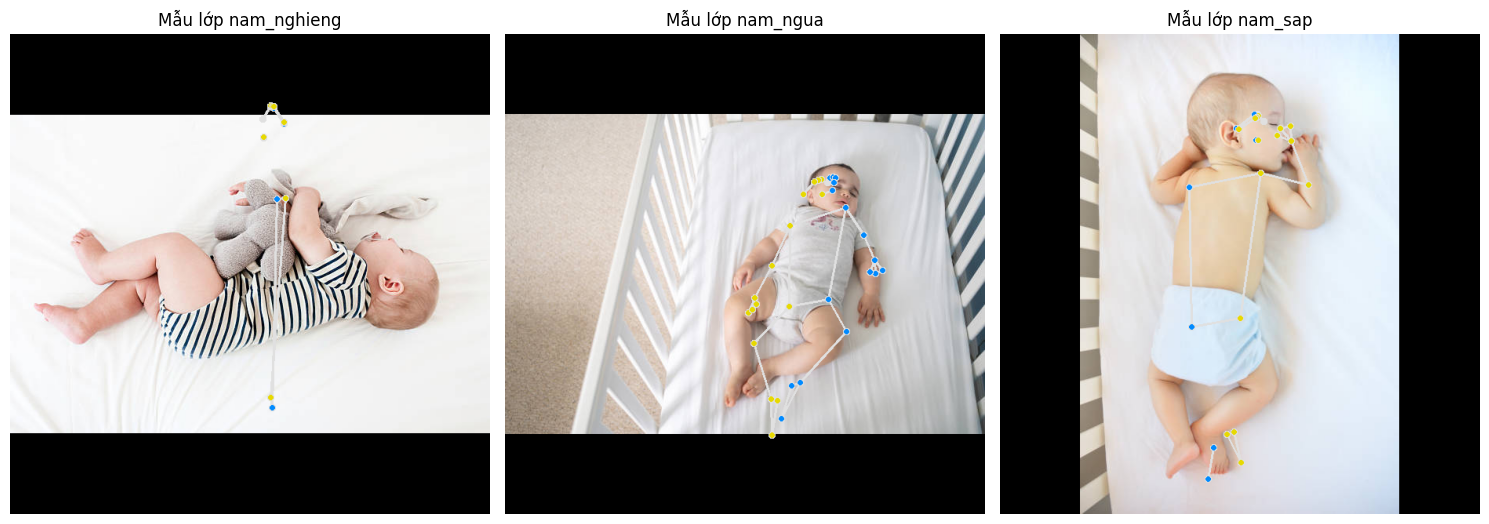

In [7]:
# Thực hiện trích xuất keypoints từ dataset
print("Bắt đầu trích xuất keypoints từ dataset...")
final_df, stats = extract_keypoints_from_dataset()

# Hiển thị thông tin về quá trình xử lý
print(f"\nTổng số ảnh: {stats['total_images']}")
print(f"Số ảnh xử lý thành công: {stats['successful_images']}")
print(f"Tỉ lệ thành công: {stats['success_rate']:.2f}%")

# Hiển thị ảnh mẫu với pose được phát hiện
visualize_sample_poses(stats['sample_images'])

Đã lưu kết quả vào file d:\GiaoPhan_Workspace\sem_6\pbl5\baby_posture_analysis\data_cleaned\keypoints_extract.csv

Thông tin dữ liệu đã trích xuất:
Kích thước: (338, 100)
Số lượng mẫu theo lớp:
label
nam_ngua       121
nam_sap        111
nam_nghieng    106
Name: count, dtype: int64

Xem một số dòng đầu tiên:


,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,left_eye_outer_x,...,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z,label
0,-0.032375,-0.443125,-0.128192,-0.013339,-0.473960,-0.159927,-0.009985,-0.472266,-0.160281,-0.006803,...,-0.057832,0.703865,0.303709,-0.211990,0.652212,0.211996,-0.120779,0.827830,0.334756,nam_nghieng
1,0.086624,-0.484814,-0.119727,0.049050,-0.508999,-0.101510,0.043915,-0.507234,-0.101985,0.038644,...,0.340321,0.419327,-0.293603,0.435128,0.586154,0.190997,0.483980,0.323302,-0.348363,nam_nghieng
2,0.039504,-0.391531,-0.277027,0.034164,-0.429585,-0.238979,0.035597,-0.432467,-0.239557,0.037350,...,0.143415,0.648804,0.085500,0.153767,0.830740,0.607296,0.216028,0.732659,0.139018,nam_nghieng
3,-0.021387,-0.424396,-0.398574,0.000573,-0.468604,-0.376664,0.010666,-0.464507,-0.377072,0.021906,...,-0.117428,0.810201,-0.054123,-0.132729,0.956947,-0.155732,-0.144058,0.955609,-0.163413,nam_nghieng
4,0.011442,-0.454324,-0.201684,0.032945,-0.436385,-0.208714,0.035106,-0.428058,-0.209211,0.037092,...,-0.104175,0.700091,-0.075656,-0.118948,0.738366,-0.263685,-0.170853,0.700027,-0.193758,nam_nghieng


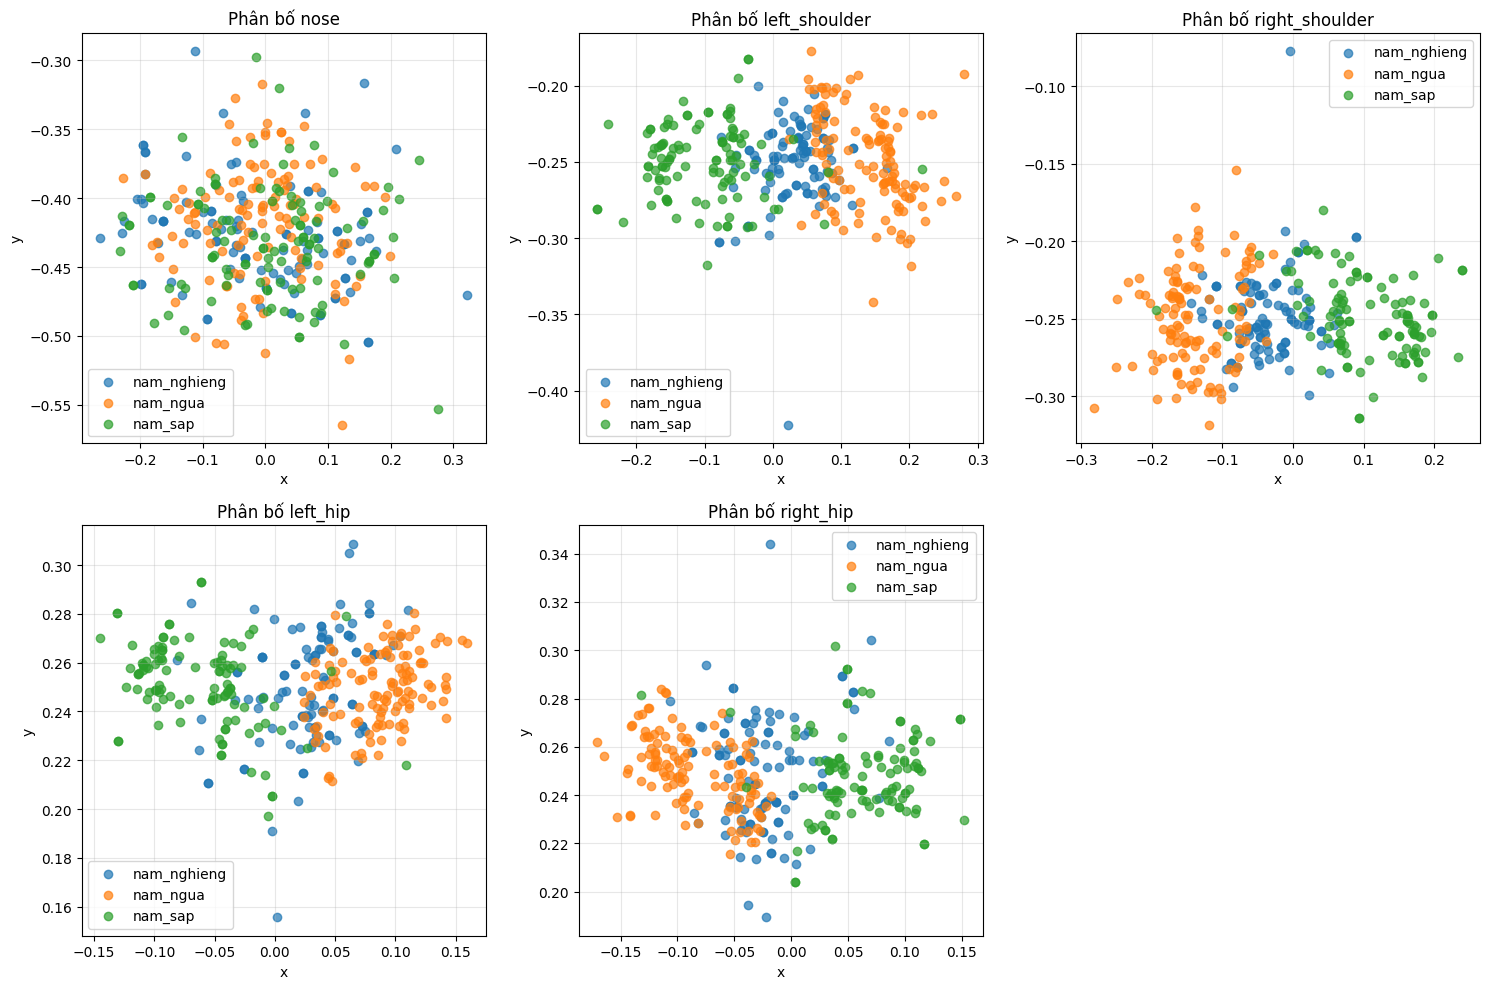

Các giá trị bị thiếu:
Series([], dtype: int64)


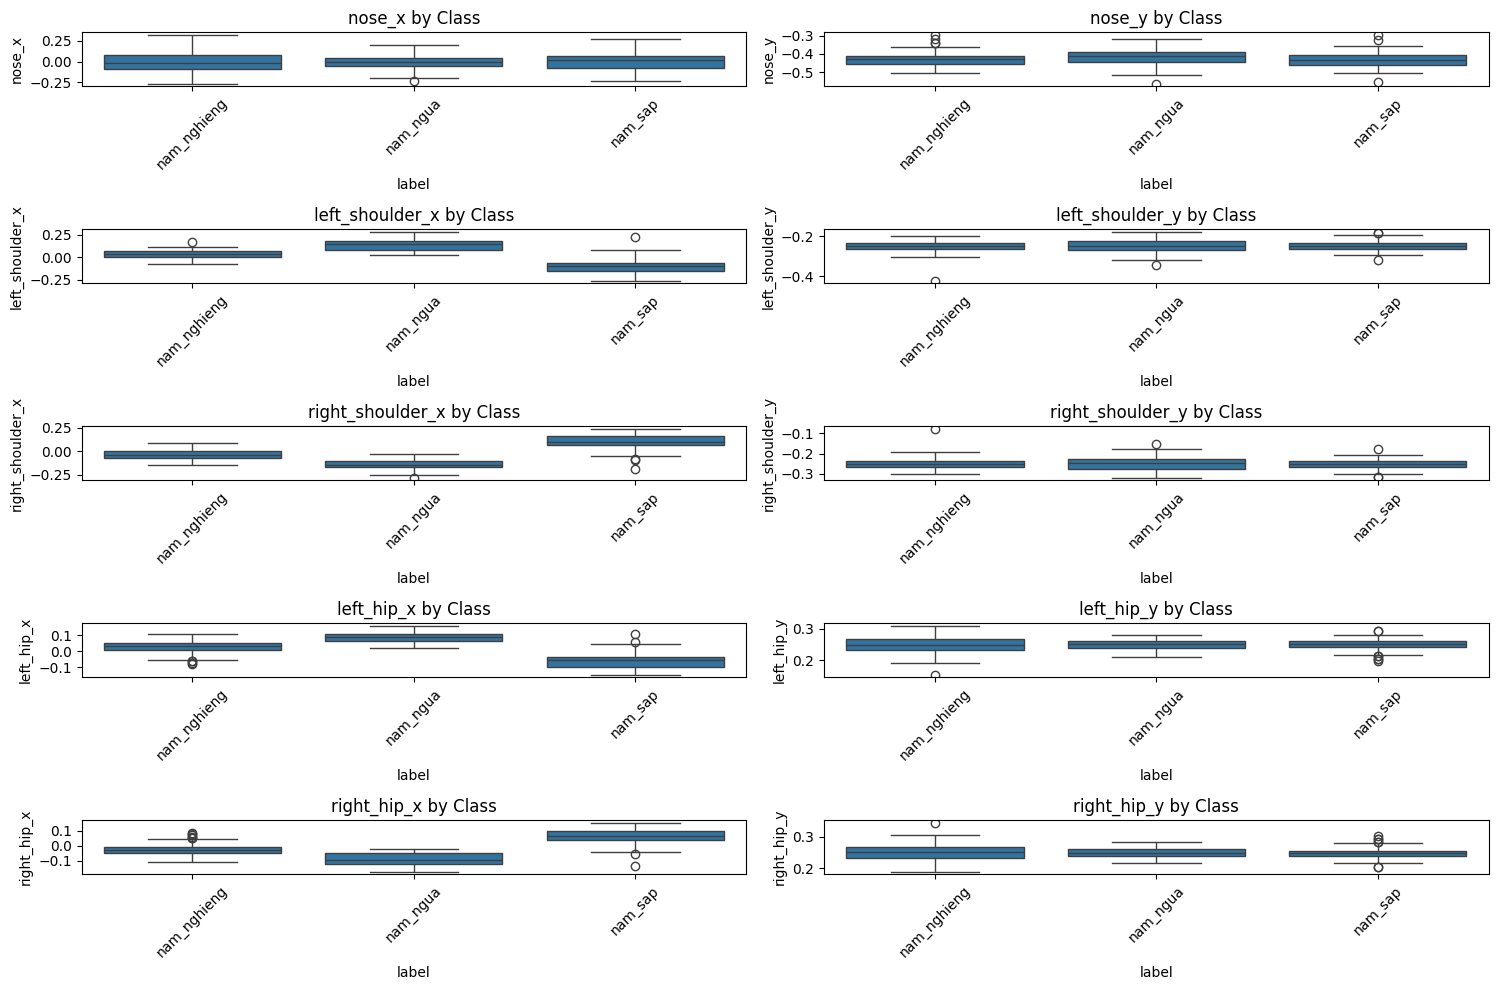


Phân phối của dữ liệu theo lớp:
label
nam_ngua       121
nam_sap        111
nam_nghieng    106
Name: count, dtype: int64


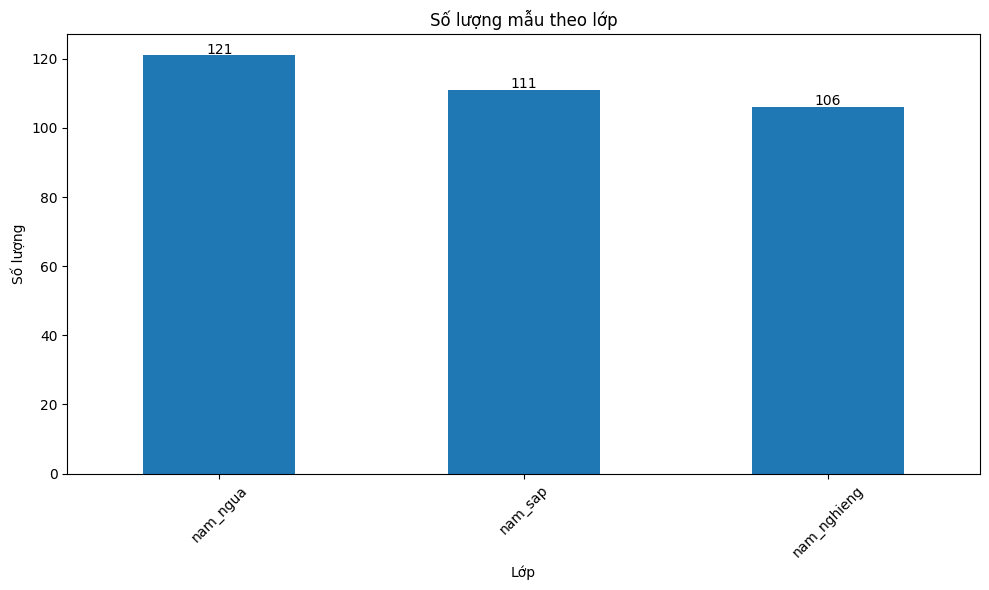

In [8]:
# Xử lý và lưu kết quả
if final_df is not None:
    # Lưu kết quả vào file CSV
    final_df.to_csv(CSV_OUTPUT_PATH, index=False)
    
    print(f"Đã lưu kết quả vào file {CSV_OUTPUT_PATH}")
    
    # Hiển thị thông tin về dữ liệu đã trích xuất
    print(f"\nThông tin dữ liệu đã trích xuất:")
    print(f"Kích thước: {final_df.shape}")
    print(f"Số lượng mẫu theo lớp:")
    print(final_df['label'].value_counts())
    
    # Hiển thị một số dòng đầu tiên
    print("\nXem một số dòng đầu tiên:")
    display(final_df.head())
    
    # Hiển thị phân phối keypoints
    visualize_keypoint_distribution(final_df)
    
    # Kiểm tra outliers
    check_outliers(final_df)
    
    # Hiển thị phân phối dữ liệu theo lớp
    visualize_class_distribution(final_df)
else:
    print("Không có dữ liệu nào được trích xuất!")

## Tóm tắt

Đã hoàn thành việc trích xuất keypoints từ các ảnh trong thư mục `/data/train` và lưu kết quả vào file `keypoints_extract.csv` trong thư mục `/data_cleaned`.

Kết quả:
- Số ảnh được xử lý thành công được ghi nhận ở trên
- Dữ liệu đã được chuẩn hóa và lưu vào file CSV
- Đã phân tích phân phối dữ liệu để kiểm tra chất lượng

Các keypoints được trích xuất từ mỗi ảnh bao gồm 33 điểm đặc trưng với tọa độ x, y, z cho mỗi điểm.